# Collaboration and Competition

---

In this notebook, we trained two RL agents to play tennis. As in real tennis, the goal of each player is to keep the ball in play. And, when you have two equally matched opponents, you tend to see fairly long exchanges where the players hit the ball back and forth over the net. We used Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## 1. Start the Environment

We begin by importing the necessary packages. 

In [25]:
#Run the following commented code if you have not installed UnityEnvironment yet
# !pip -q install ./python


In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random

from torch.autograd import Variable
from torch import nn
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim
from model import Actor, Critic
import matplotlib.pyplot as plt
%matplotlib inline

 <span style="color:red">First, you must download the environment relevant to your machine (links are given inside readme), then unzip the file.</span>

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name='Tennis_Windows_x86_64/Tennis.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

Run the code cell below to print some information about the environment

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

## 4. Training the agents using MADDPG


The agent is a MADDPG or Deep Deterministic Policy gradient. 


The Hyperparamters below performed great with high results and steady learning curve. Feel free to play with these 

    ```
	BUFFER_SIZE = int(1e6)  # replay buffer size
    BATCH_SIZE = 1024     # minibatch size
    GAMMA = 0.99            # discount factor
    TAU = 1e-3              # for soft update of target parameters
    LR_ACTOR = 1e-4         # learning rate of the actor 
    LR_CRITIC = 1e-3        # learning rate of the critic
    WEIGHT_DECAY = 0        # L2 weight decay
	```




In [8]:
from ddpg_agent import Agent

agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=4)

In [21]:
def maddpg(n_episodes=1000000, max_steps=10000, multi_agent=False, multi_replay=False, split_replay=False):
    scores_mean = deque(maxlen=100)
    scores = []
    ave_scores = []

    best_score = 0
    best_average_score = 0
    for i_episode in range(1, n_episodes+1):                       
        average_score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations            
        scores_agents = np.zeros(num_agents)             
        score = 0
        if multi_agent:
            agent1.reset()
            agent2.reset()
        else:
            agent1.reset()

        for step in range(max_steps):
            if multi_agent:
                actions = np.random.randn(num_agents, action_size)
                actions[0] = agent1.act(states[0])                  # select an action (for each agent)
                actions[1] = agent2.act(states[1])
            else: 
                actions = agent1.act(states)
            env_info = env.step(actions)[brain_name]     
            next_states = env_info.vector_observations   
            rewards = env_info.rewards                   
            dones = env_info.local_done
            if multi_replay:
                if split_replay:
                    agent1.step(states[0], actions[0], rewards[0], next_states[0], dones[0], step)
                    agent2.step(states[1], actions[1], rewards[1], next_states[1], dones[1], step)
                else:
                    agent1.step(states, actions, rewards, next_states, dones, step)
                    agent2.step(states, actions, rewards, next_states, dones, step)
                
            else:             
                agent1.step(states, actions, rewards, next_states, dones, step)
                
            states = next_states
            scores_agents += rewards
            if np.any(dones):
                break

        score = scores_agents.max()
        scores_mean.append(score)
        average_score = np.mean(scores_mean)
        scores.append(score)
        ave_scores.append(average_score)
        
        if score > best_score:
            best_score = score
        if average_score > best_average_score:
            best_average_score = average_score
        
        print("Episode:{}, Low Score:{:.2f}, High Score:{:.2f}, Score:{:.2f}, Best Score:{:.2f}, Average Score:{:.2f}, Best Avg Score:{:.2f}".format(i_episode, scores_agents.min(), scores_agents.max(), score, best_score, average_score, best_average_score))
        if average_score > 0.5:
            print("Episode:{}, Low Score:{:.2f}, High Score:{:.2f}, Score:{:.2f}, Best Score:{:.2f}, Average Score:{:.2f}, Best Avg Score:{:.2f}".format(i_episode, scores_agents.min(), scores_agents.max(), score, best_score, average_score, best_average_score))

            if multi_agent:
                torch.save(agent1.actor_local.state_dict(), 'checkpoint_actorma.pth')
                torch.save(agent1.critic_local.state_dict(), 'checkpoint_criticma.pth') 
                torch.save(agent2.actor_local.state_dict(), 'checkpoint_actorma.pth')
                torch.save(agent2.critic_local.state_dict(), 'checkpoint_criticma.pth')
            elif split_replay:
                torch.save(agent1.actor_local.state_dict(), 'checkpoint_actorsr.pth')
                torch.save(agent1.critic_local.state_dict(), 'checkpoint_criticsr.pth') 
                torch.save(agent2.actor_local.state_dict(), 'checkpoint_actorsr.pth')
                torch.save(agent2.critic_local.state_dict(), 'checkpoint_criticsr.pth')
            else:
                torch.save(agent1.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent1.critic_local.state_dict(), 'checkpoint_critic.pth') 
                    

            break
    return scores, ave_scores

#scores = ddpg()

In [23]:
from ddpg_agent import Agent

agent1 = Agent(state_size=state_size, action_size=action_size, random_seed=4, mnoise=False)
agent2 = Agent(state_size=state_size, action_size=action_size, random_seed=4, mnoise=False)

In [24]:
scores, ave_scores = maddpg(n_episodes=10000, max_steps=10000, multi_agent=True, multi_replay=True, split_replay=False)

Episode:1, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:2, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.00, Average Score:0.00, Best Avg Score:0.00
Episode:3, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.10, Average Score:0.03, Best Avg Score:0.03
Episode:4, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.03, Best Avg Score:0.03
Episode:5, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.02, Best Avg Score:0.03
Episode:6, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.02, Best Avg Score:0.03
Episode:7, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:8, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.10, Average Score:0.03, Best Avg Score:0.03
Episode:9, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:

Episode:73, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:74, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:75, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:76, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:77, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:78, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:79, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:80, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:81, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Avera

Episode:144, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:145, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:146, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:147, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:148, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:149, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:150, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:151, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.01, Best Avg Score:0.03
Episode:152, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:215, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:216, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:217, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:218, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:219, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:220, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:221, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:222, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:223, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:286, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:287, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:288, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:289, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:290, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:291, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:292, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:293, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.10, Average Score:0.00, Best Avg Score:0.03
Episode:294, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:357, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:358, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:359, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:360, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:361, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:362, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:363, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:364, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:365, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:428, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:429, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:430, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:431, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:432, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:433, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:434, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:435, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.00, Best Avg Score:0.03
Episode:436, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:499, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:500, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:501, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:502, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:503, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:504, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:505, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:506, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:0.20, Average Score:0.01, Best Avg Score:0.03
Episode:507, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.2

Episode:570, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:571, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:572, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:573, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:574, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:575, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:576, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:577, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:578, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:641, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:642, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:643, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:644, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:645, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:646, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:647, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:648, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:649, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.

Episode:712, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:713, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:714, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:715, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.02, Best Avg Score:0.03
Episode:716, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:717, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:718, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:719, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.03, Best Avg Score:0.03
Episode:720, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.

Episode:783, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:784, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:785, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:786, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:787, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:788, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:789, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:790, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.04, Best Avg Score:0.04
Episode:791, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20,

Episode:854, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.05
Episode:855, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.05, Best Avg Score:0.05
Episode:856, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.05, Best Avg Score:0.05
Episode:857, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.05
Episode:858, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, Average Score:0.05, Best Avg Score:0.05
Episode:859, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.05, Best Avg Score:0.05
Episode:860, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.20, Average Score:0.05, Best Avg Score:0.05
Episode:861, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.20, Average Score:0.05, Best Avg Score:0.05
Episode:862, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.20, 

Episode:925, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.08, Best Avg Score:0.08
Episode:926, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.08, Best Avg Score:0.08
Episode:927, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.08, Best Avg Score:0.08
Episode:928, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.30, Average Score:0.08, Best Avg Score:0.08
Episode:929, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.08, Best Avg Score:0.08
Episode:930, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.08, Best Avg Score:0.08
Episode:931, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.08, Best Avg Score:0.08
Episode:932, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.30, Average Score:0.08, Best Avg Score:0.08
Episode:933, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.3

Episode:996, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:997, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:998, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:999, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:1000, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:1001, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:1002, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:1003, Low Score:0.19, High Score:0.30, Score:0.30, Best Score:0.30, Average Score:0.10, Best Avg Score:0.10
Episode:1004, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.3

Episode:1067, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.12, Best Avg Score:0.12
Episode:1068, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.50, Average Score:0.12, Best Avg Score:0.12
Episode:1069, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.12, Best Avg Score:0.12
Episode:1070, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.12, Best Avg Score:0.12
Episode:1071, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.12, Best Avg Score:0.12
Episode:1072, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:0.50, Average Score:0.12, Best Avg Score:0.12
Episode:1073, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.12, Best Avg Score:0.12
Episode:1074, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.50, Average Score:0.12, Best Avg Score:0.12
Episode:1075, Low Score:-0.01, High Score:0.10, Score:0.10, Best Sc

Episode:1138, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.15, Best Avg Score:0.15
Episode:1139, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.50, Average Score:0.15, Best Avg Score:0.15
Episode:1140, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.50, Average Score:0.15, Best Avg Score:0.15
Episode:1141, Low Score:0.08, High Score:0.10, Score:0.10, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:1142, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:1143, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:1144, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:1145, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:0.50, Average Score:0.14, Best Avg Score:0.15
Episode:1146, Low Score:0.09, High Score:0.10, Score:0.10, Best Scor

Episode:1209, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.18, Best Avg Score:0.19
Episode:1210, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:0.70, Average Score:0.19, Best Avg Score:0.19
Episode:1211, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.19, Best Avg Score:0.19
Episode:1212, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:0.70, Average Score:0.19, Best Avg Score:0.19
Episode:1213, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.70, Average Score:0.19, Best Avg Score:0.19
Episode:1214, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.19, Best Avg Score:0.19
Episode:1215, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.70, Average Score:0.19, Best Avg Score:0.19
Episode:1216, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.70, Average Score:0.18, Best Avg Score:0.19
Episode:1217, Low Score:0.29, High Score:0.40, Score:0.40, Best Score:0

Episode:1280, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.70, Average Score:0.16, Best Avg Score:0.19
Episode:1281, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.16, Best Avg Score:0.19
Episode:1282, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.16, Best Avg Score:0.19
Episode:1283, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.16, Best Avg Score:0.19
Episode:1284, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.15, Best Avg Score:0.19
Episode:1285, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.15, Best Avg Score:0.19
Episode:1286, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.15, Best Avg Score:0.19
Episode:1287, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.15, Best Avg Score:0.19
Episode:1288, Low Score:-0.01, High Score:0.10, Score:0.10, Best S

Episode:1351, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.11, Best Avg Score:0.19
Episode:1352, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.70, Average Score:0.11, Best Avg Score:0.19
Episode:1353, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.11, Best Avg Score:0.19
Episode:1354, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0.70, Average Score:0.11, Best Avg Score:0.19
Episode:1355, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.70, Average Score:0.11, Best Avg Score:0.19
Episode:1356, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.11, Best Avg Score:0.19
Episode:1357, Low Score:0.09, High Score:0.30, Score:0.30, Best Score:0.70, Average Score:0.11, Best Avg Score:0.19
Episode:1358, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:0.70, Average Score:0.12, Best Avg Score:0.19
Episode:1359, Low Score:0.00, High Score:0.09, Score:0.09, Best Score:0

Episode:1422, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:0.70, Average Score:0.11, Best Avg Score:0.19
Episode:1423, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:0.70, Average Score:0.12, Best Avg Score:0.19
Episode:1424, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.12, Best Avg Score:0.19
Episode:1425, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.12, Best Avg Score:0.19
Episode:1426, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.12, Best Avg Score:0.19
Episode:1427, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.12, Best Avg Score:0.19
Episode:1428, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.70, Average Score:0.12, Best Avg Score:0.19
Episode:1429, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.12, Best Avg Score:0.19
Episode:1430, Low Score:0.19, High Score:0.20, Score:0.20, Best Score

Episode:1493, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.14, Best Avg Score:0.19
Episode:1494, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:0.70, Average Score:0.14, Best Avg Score:0.19
Episode:1495, Low Score:0.20, High Score:0.29, Score:0.29, Best Score:0.70, Average Score:0.15, Best Avg Score:0.19
Episode:1496, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:0.70, Average Score:0.15, Best Avg Score:0.19
Episode:1497, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:0.70, Average Score:0.15, Best Avg Score:0.19
Episode:1498, Low Score:0.69, High Score:0.70, Score:0.70, Best Score:0.70, Average Score:0.16, Best Avg Score:0.19
Episode:1499, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:0.70, Average Score:0.16, Best Avg Score:0.19
Episode:1500, Low Score:0.49, High Score:0.50, Score:0.50, Best Score:0.70, Average Score:0.16, Best Avg Score:0.19
Episode:1501, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.

Episode:1564, Low Score:0.59, High Score:0.60, Score:0.60, Best Score:0.80, Average Score:0.22, Best Avg Score:0.22
Episode:1565, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.80, Average Score:0.22, Best Avg Score:0.22
Episode:1566, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:0.80, Average Score:0.22, Best Avg Score:0.22
Episode:1567, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.80, Average Score:0.22, Best Avg Score:0.22
Episode:1568, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:0.80, Average Score:0.22, Best Avg Score:0.22
Episode:1569, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.80, Average Score:0.22, Best Avg Score:0.22
Episode:1570, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:0.80, Average Score:0.22, Best Avg Score:0.22
Episode:1571, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.80, Average Score:0.22, Best Avg Score:0.22
Episode:1572, Low Score:-0.01, High Score:0.00, Score:0.00, Best Sco

Episode:1635, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.90, Average Score:0.25, Best Avg Score:0.25
Episode:1636, Low Score:0.39, High Score:0.50, Score:0.50, Best Score:0.90, Average Score:0.25, Best Avg Score:0.25
Episode:1637, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:0.90, Average Score:0.25, Best Avg Score:0.25
Episode:1638, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:0.90, Average Score:0.25, Best Avg Score:0.25
Episode:1639, Low Score:0.10, High Score:0.19, Score:0.19, Best Score:0.90, Average Score:0.25, Best Avg Score:0.25
Episode:1640, Low Score:-0.01, High Score:0.10, Score:0.10, Best Score:0.90, Average Score:0.25, Best Avg Score:0.25
Episode:1641, Low Score:0.59, High Score:0.60, Score:0.60, Best Score:0.90, Average Score:0.25, Best Avg Score:0.25
Episode:1642, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:0.90, Average Score:0.25, Best Avg Score:0.25
Episode:1643, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:

Episode:1706, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:1.20, Average Score:0.25, Best Avg Score:0.26
Episode:1707, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.20, Average Score:0.25, Best Avg Score:0.26
Episode:1708, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:1.20, Average Score:0.25, Best Avg Score:0.26
Episode:1709, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.20, Average Score:0.25, Best Avg Score:0.26
Episode:1710, Low Score:-0.01, High Score:0.00, Score:0.00, Best Score:1.20, Average Score:0.25, Best Avg Score:0.26
Episode:1711, Low Score:0.20, High Score:0.29, Score:0.29, Best Score:1.20, Average Score:0.25, Best Avg Score:0.26
Episode:1712, Low Score:0.09, High Score:0.20, Score:0.20, Best Score:1.20, Average Score:0.25, Best Avg Score:0.26
Episode:1713, Low Score:0.69, High Score:0.70, Score:0.70, Best Score:1.20, Average Score:0.25, Best Avg Score:0.26
Episode:1714, Low Score:0.49, High Score:0.50, Score:0.50, Best Score:

Episode:1777, Low Score:1.49, High Score:1.60, Score:1.60, Best Score:2.60, Average Score:0.38, Best Avg Score:0.38
Episode:1778, Low Score:0.89, High Score:0.90, Score:0.90, Best Score:2.60, Average Score:0.39, Best Avg Score:0.39
Episode:1779, Low Score:0.39, High Score:0.40, Score:0.40, Best Score:2.60, Average Score:0.39, Best Avg Score:0.39
Episode:1780, Low Score:1.19, High Score:1.30, Score:1.30, Best Score:2.60, Average Score:0.40, Best Avg Score:0.40
Episode:1781, Low Score:0.09, High Score:0.10, Score:0.10, Best Score:2.60, Average Score:0.40, Best Avg Score:0.40
Episode:1782, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:2.60, Average Score:0.40, Best Avg Score:0.40
Episode:1783, Low Score:0.29, High Score:0.30, Score:0.30, Best Score:2.60, Average Score:0.40, Best Avg Score:0.40
Episode:1784, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:2.60, Average Score:0.40, Best Avg Score:0.40
Episode:1785, Low Score:0.19, High Score:0.20, Score:0.20, Best Score:2.

In [28]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

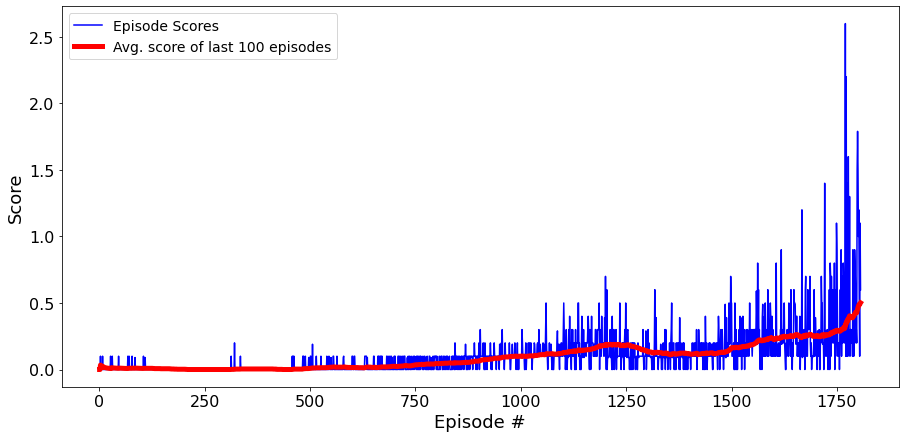

In [30]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,'b',label='Episode Scores')
plt.plot(np.arange(1, len(scores)+1), ave_scores,'r',\
         linewidth=5,label='Avg. score of last 100 episodes')
plt.ylabel('Score', fontsize=18)
plt.xlabel('Episode #', fontsize=18)
ax.legend(fontsize=14)
plt.show()

## 9 Load the saved weights for the network

In [33]:
from ddpg_agent import Agent

agent3 = Agent(state_size=state_size, action_size=action_size, random_seed=4, mnoise=False, split_state=False)

In [35]:
agent3.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location='cpu'))
agent3.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location='cpu'))

<All keys matched successfully>

## 10: Now sit back and watch some Tennis .

In [42]:
# watch the Master agent
def maddpg(n_episodes=1, max_steps=400):
    scores_hundred_queue = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations            
        scores_agents = np.zeros(num_agents)             
        agent3.reset()
        score = 0
        for step in range(max_steps):
            actions = agent1.act(states)
            env_info = env.step(actions)[brain_name]     
            next_states = env_info.vector_observations   
            rewards = env_info.rewards                   
            dones = env_info.local_done                  
            agent3.step(states, actions, rewards, next_states, dones, step)
            states = next_states
            scores_agents += rewards
            if np.any(dones):
                break
        score = score = scores_agents.max()
        scores.append(score)        
        print("Episode: ", i_episode)
        print("Score: {:.2f}".format(score))
    
       
        
      
    return scores

scores = maddpg()

Episode:  1
Score: 0.90


In [1]:
# env.close()

NameError: name 'env' is not defined